In [1]:
from theano import gpuarray
from __future__ import print_function, division

import utils; reload(utils)
from utils import *

from IPython.display import FileLink

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 73, in init_dev
    pygpu_version.fullversion)
ValueError: Your installed version of pygpu(0.6.9) is too old, please upgrade to 0.7.0 or later (but below 0.8.0)
Using Theano backend.


## Create Train/Valid datasets

In [2]:
import make_train_val as mtv
import os
import numpy as np

In [3]:
pwd

u'/home/ubuntu/courses/deeplearning1/nbs'

In [4]:
path = os.getcwd() + '/data/lesson3_HW_Kaggle/'
path

'/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/'

In [5]:
# Get all files in all directories following this pattern
from glob import glob
g = glob(path + 'train/'+ 'c?/*.jpg')
g[:5]
len(g) * .80

14351.2

In [6]:
shuf = np.random.permutation(g)
shuf

array(['/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/train/c9/img_84171.jpg',
       '/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/train/c2/img_72490.jpg',
       '/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/train/c0/img_69408.jpg', ...,
       '/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/train/c0/img_4053.jpg',
       '/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/train/c7/img_62818.jpg',
       '/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/train/c9/img_49442.jpg'],
      dtype='|S85')

In [7]:
p = '/'.join(path.split('/')[1:-1][-2:])
p

'data/lesson3_HW_Kaggle'

In [8]:
path.split('/')[1:-1][-2:]

['data', 'lesson3_HW_Kaggle']

In [9]:
path

'/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/'

In [10]:
classes = ['c'+str(i) for i in range(10)]
classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [11]:
mtv.create_train_val_dirs(path, classes)
mtv.create_sample_dirs(path, classes)

Validation directories already contain files
Samples directories created with copies of files for train and validation
Sample test directory created


#### Plot class sizes

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

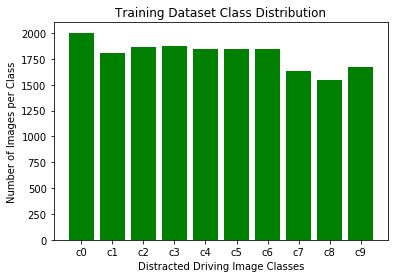

In [13]:
from collections import defaultdict
import os

path = './data/lesson3_HW_Kaggle/train/'
class_dirs = os.listdir('./data/lesson3_HW_Kaggle/train/')
class_size = defaultdict()

for c in class_dirs:
    class_size[c] = len([f for f in os.listdir(path+c+'/') if os.path.isfile(os.path.join(path+c+'/', f))])

plt.bar(class_size.keys(), class_size.values(), color='g')
plt.title("Training Dataset Class Distribution")
plt.xlabel("Distracted Driving Image Classes")
plt.ylabel("Number of Images per Class");

Looks like we have pretty balanced classes for both the training and validation datasets

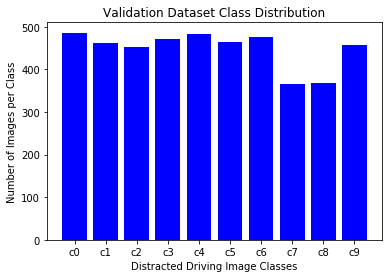

In [14]:
path = './data/lesson3_HW_Kaggle/valid/'
class_dirs = os.listdir('./data/lesson3_HW_Kaggle/valid/')
class_size = defaultdict()

for c in class_dirs:
    class_size[c] = len([f for f in os.listdir(path+c+'/') if os.path.isfile(os.path.join(path+c+'/', f))])

plt.bar(class_size.keys(), class_size.values(), color='b')
plt.title("Validation Dataset Class Distribution")
plt.xlabel("Distracted Driving Image Classes")
plt.ylabel("Number of Images per Class");

## Load pretrained weights from ResNet

In [15]:
!tree -d './data/lesson3_HW_Kaggle/'

./data/lesson3_HW_Kaggle/
├── sample
│   ├── test
│   │   └── test_sub
│   ├── train
│   │   ├── c0
│   │   ├── c1
│   │   ├── c2
│   │   ├── c3
│   │   ├── c4
│   │   ├── c5
│   │   ├── c6
│   │   ├── c7
│   │   ├── c8
│   │   └── c9
│   └── valid
│       ├── c0
│       ├── c1
│       ├── c2
│       ├── c3
│       ├── c4
│       ├── c5
│       ├── c6
│       ├── c7
│       ├── c8
│       └── c9
├── test
│   └── test_sub
├── train
│   ├── c0
│   ├── c1
│   ├── c2
│   ├── c3
│   ├── c4
│   ├── c5
│   ├── c6
│   ├── c7
│   ├── c8
│   └── c9
└── valid
    ├── c0
    ├── c1
    ├── c2
    ├── c3
    ├── c4
    ├── c5
    ├── c6
    ├── c7
    ├── c8
    └── c9

49 directories


In [24]:
path = os.getcwd() + '/data/lesson3_HW_Kaggle/'
path

'/home/ubuntu/courses/deeplearning1/nbs/data/lesson3_HW_Kaggle/'

In [25]:
'''
Something here causing test set not to batch (look into sample being in the same level directory)...
Ended up being the thing about keras needing subdirectories for each class. For the test set which is unlabeled, 
just create a new subdirectory called somthing like 'test_sub' and put it into test
https://keras.io/preprocessing/image/
'''

# get the one-hot encoded labels and other info 
val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames = get_classes(path)


Found 17939 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [26]:
batch_size = 64

# Add data augmentation to training batches
aug_gen = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.5,
                                  shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path + 'train/', aug_gen, batch_size=batch_size)

# We don't want to add augmentation to validation since we these are the images we want predictions for
val_batches = get_batches(path + 'valid/', batch_size=batch_size*2, shuffle=False)

Found 17939 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.
